In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess

from datetime import date

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

USER = os.environ['USER']
os.environ['CESMDATAROOT'] = f'/glade/scratch/{USER}/inputdata'
import pop_tools

import regrid_tools
import util

In [3]:
mom6_grid_file = '/glade/p/cesmdata/cseg/inputdata/share/scripgrids/tx0.66v1_SCRIP_190314.nc'
fesedflux_file = '/glade/work/mclong/cesm_inputdata/fesedflux_total_reduce_oxic_POP_gx1v7.c200618.nc'


src_grid = regrid_tools.grid('POP_gx1v7', clobber=False)
dst_grid = regrid_tools.grid('tx0.66v1', grid_file=mom6_grid_file)
method = 'conserve'

regridder = regrid_tools.regridder(src_grid, dst_grid, method, clobber=False)
regridder

/glade/work/mlevy/miniconda3/envs/forcing-Fe-sedflux/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


writing: /glade/work/mlevy/adhoc-regridding/POP_gx1v7.nc
generating: /glade/work/mlevy/adhoc-regridding/POP_gx1v7_to_tx0.66v1_conserve.nc
 Starting weight generation with these inputs: 
   Source File: /glade/work/mlevy/adhoc-regridding/POP_gx1v7.nc
   Destination File: /glade/p/cesmdata/cseg/inputdata/share/scripgrids/tx0.66v1_SCRIP_190314.nc
   Weight File: /glade/work/mlevy/adhoc-regridding/POP_gx1v7_to_tx0.66v1_conserve.nc
   Source File is in SCRIP format
   Source Grid is a global grid
   Source Grid is a logically rectangular grid
   Use the center coordinates of the source grid to do the regrid
   Destination File is in SCRIP format
   Destination Grid is a global grid
   Destination Grid is a logically rectangular grid
   Use the center coordinates of the destination grid to do the regrid
   Regrid Method: conserve
   Pole option: NONE
   Ignore unmapped destination points
   Output weight file in NetCDF4 file format
   Line Type: greatcircle
   Norm Type: dstarea
   Extrap. M

regridder POP_gx1v7.nc --> tx0.66v1_SCRIP_190314.nc

In [4]:
ds_src = xr.open_dataset(fesedflux_file)
ds_src.info()

xarray.Dataset {
dimensions:
	z_t = 60 ;
	nlat = 384 ;
	nlon = 320 ;

variables:
	float32 FESEDFLUXIN(z_t, nlat, nlon) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe sediment flux (total) ;
	float32 FESEDFLUXIN_oxic(z_t, nlat, nlon) ;
		FESEDFLUXIN_oxic:units = micromol m$^{-2}$ d$^{-1}$ ;
		FESEDFLUXIN_oxic:long_name = Fe sediment flux (oxic) ;
	float32 FESEDFLUXIN_reduce(z_t, nlat, nlon) ;
		FESEDFLUXIN_reduce:units = micromol m$^{-2}$ d$^{-1}$ ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
	float64 TLAT(nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TLONG(nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	float64 z_t(z_t) ;
		z_t:units = cm ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:positive = down ;

// global attributes:
	:history

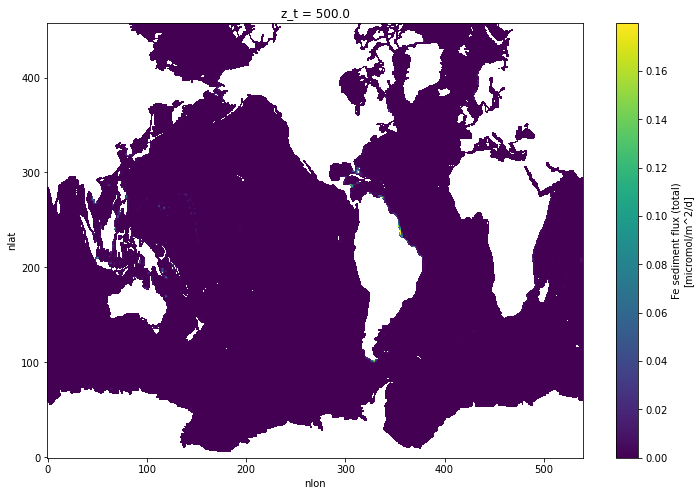

In [5]:
ds_dst_xy = regridder.regrid(ds_src, renormalize=True, apply_mask=True)
ds_dst_xy.isel(z_t=0).FESEDFLUXIN.plot(figsize=[12,8])

In [6]:
# depth = xr.DataArray(
#     np.concatenate((
#         np.arange(0., 105., 5.), 
#         np.arange(125., 525., 25.), 
#         np.arange(550., 2050., 50.), 
#         np.arange(2100., 5600., 100.), # MNL: changed 6600 -> 5600 to match initial condition depths
#     )), 
#     dims=('DEPTH'), 
#     name='DEPTH',
#     attrs=dict(
#         long_name='Depth',
#         units='m',
#     )
# )

if ds_dst_xy['z_t'].attrs['units'] == 'cm':
    ds_dst = ds_dst_xy.assign_coords(z_t=ds_dst_xy['z_t'].data/100.)
    ds_dst['z_t'].attrs['units'] = 'm'
    ds_dst['z_t'].attrs['edges'] = 'DEPTH_EDGES'
else:
    ds_dst = ds_dst_xy

# Add edges to ds_dst
da_edges = xr.DataArray([0.] + list(pop_tools.get_grid('POP_gx1v7')['z_w_bot'].data/100.),
                        name='DEPTH_EDGES',
                        dims='DEPTH_EDGES')
da_edges.attrs['units'] = 'm'
da_edges
ds_dst['DEPTH_EDGES'] = da_edges

# depth
ds_dst = ds_dst.rename({'nlat': 'NLAT', 'nlon': 'NLON', 'z_t': 'DEPTH'})
ds_dst

<xarray.Dataset>
Dimensions:             (DEPTH: 60, NLAT: 458, NLON: 540, DEPTH_EDGES: 61)
Coordinates:
  * DEPTH               (DEPTH) float64 5.0 15.0 25.0 ... 5.125e+03 5.375e+03
  * DEPTH_EDGES         (DEPTH_EDGES) float64 0.0 10.0 20.0 ... 5.25e+03 5.5e+03
Dimensions without coordinates: NLAT, NLON
Data variables:
    FESEDFLUXIN         (DEPTH, NLAT, NLON) float64 nan nan nan ... nan nan nan
    FESEDFLUXIN_oxic    (DEPTH, NLAT, NLON) float64 nan nan nan ... nan nan nan
    FESEDFLUXIN_reduce  (DEPTH, NLAT, NLON) float64 nan nan nan ... nan nan nan
    KMT                 (NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    TAREA               (NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    history:  Thu Jun 18 13:21:06 2020: ncks -O --fl_fmt=64bit /glade/work/mc...
    NCO:      netCDF Operators version 4.7.9 (Homepage = http://nco.sf.net, C...

### NO VERTICAL REGRIDDING

For now, we are leaving output on the POP vertical grid (with proper units)

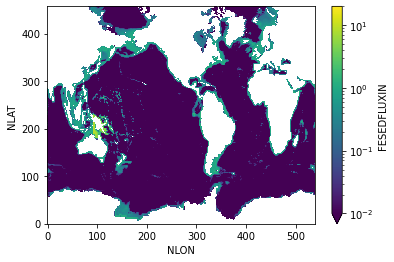

In [7]:
ds_dst.FESEDFLUXIN.sum('DEPTH').plot(norm=colors.LogNorm(vmin=1e-2, vmax=20.))

In [8]:
ds_dst.attrs['note'] = f'temporary forcing file remapped from: {fesedflux_file}'
datestamp = date.today().strftime('%y%m%d')
path = f'{util.dirout}/fesedflux_total_reduce_oxic_{dst_grid.grid_name}.c{datestamp}.nc'


util.to_netcdf_clean(ds_dst, path, format='netcdf4')
util.ncks_fl_fmt64bit(path)

------------------------------
Writing /glade/work/mlevy/cesm_inputdata/fesedflux_total_reduce_oxic_tx0.66v1.c211019.nc
xarray.Dataset {
dimensions:
	DEPTH = 60 ;
	NLAT = 458 ;
	NLON = 540 ;
	DEPTH_EDGES = 61 ;

variables:
	float64 DEPTH(DEPTH) ;
		DEPTH:units = m ;
		DEPTH:edges = DEPTH_EDGES ;
	float64 FESEDFLUXIN(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe sediment flux (total) ;
	float64 FESEDFLUXIN_oxic(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN_oxic:units = micromol m$^{-2}$ d$^{-1}$ ;
		FESEDFLUXIN_oxic:long_name = Fe sediment flux (oxic) ;
	float64 FESEDFLUXIN_reduce(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN_reduce:units = micromol m$^{-2}$ d$^{-1}$ ;
	float64 KMT(NLAT, NLON) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
	float64 TAREA(NLAT, NLON) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
	float64 DEPTH_EDGES(DEPTH_EDGES) ;
		DEPTH_EDGES:units = m ;

// global attributes:
	:history = Thu Jun 18 13:21:06 2020: nck

In [9]:
feventflux_file = f'{util.inputdata}/ocn/pop/gx1v7/forcing/feventflux_gx1v6_5gmol_cesm1_97_2017.nc'
ds_src_vent = xr.open_dataset(feventflux_file).rename(
    x='nlon',
    y='nlat',
    z='z_t',
)
ds_src_vent = xr.merge((ds_src_vent, pop_tools.get_grid('POP_gx1v7')[['z_t',]]))

# ds_src_vent.FESEDFLUXIN = pop_tools.lateral_fill(ds_src_vent.FESEDFLUXIN, isvalid_mask=(ds_src.KMT>=0))
ds_src_vent.FESEDFLUXIN.attrs['units'] = 'micromol/m^2/d'
ds_src_vent.FESEDFLUXIN.attrs['long_name'] = 'Fe geothermal vent flux'
ds_src_vent.z_t.attrs['units'] = 'cm'

ds_src_vent.info()

xarray.Dataset {
dimensions:
	z_t = 60 ;
	nlat = 384 ;
	nlon = 320 ;

variables:
	float64 z_t(z_t) ;
		z_t:units = cm ;
	float32 FESEDFLUXIN(z_t, nlat, nlon) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe geothermal vent flux ;

// global attributes:
}

In [10]:
ds_src_vent.FESEDFLUXIN.min()

<xarray.DataArray 'FESEDFLUXIN' ()>
array(0.)

In [11]:
ds_dst_vent_xy = regridder.regrid(ds_src_vent, renormalize=True, apply_mask=True)
ds_dst_vent_xy

<xarray.Dataset>
Dimensions:      (z_t: 60, nlat: 458, nlon: 540)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    FESEDFLUXIN  (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan

In [12]:
# ds_dst_vent = regrid_vertical(ds_dst_vent_xy)

if ds_dst_vent_xy['z_t'].attrs['units'] == 'cm':
    ds_dst_vent = ds_dst_vent_xy.assign_coords(z_t=ds_dst_vent_xy['z_t'].data/100.)
    ds_dst_vent['z_t'].attrs['units'] = 'm'
    ds_dst_vent['z_t'].attrs['edges'] = 'DEPTH_EDGES'
else:
    ds_dst_vent = ds_dst_vent_xy

ds_dst_vent['DEPTH_EDGES'] = da_edges

# depth
ds_dst_vent = ds_dst_vent.rename({'nlat': 'NLAT', 'nlon': 'NLON', 'z_t': 'DEPTH'})
ds_dst_vent

<xarray.Dataset>
Dimensions:      (DEPTH: 60, NLAT: 458, NLON: 540, DEPTH_EDGES: 61)
Coordinates:
  * DEPTH        (DEPTH) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
  * DEPTH_EDGES  (DEPTH_EDGES) float64 0.0 10.0 20.0 ... 5e+03 5.25e+03 5.5e+03
Dimensions without coordinates: NLAT, NLON
Data variables:
    FESEDFLUXIN  (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan

In [13]:
ds_dst_vent.attrs['note'] = f'temporary forcing file remapped from: {feventflux_file}'
datestamp = date.today().strftime('%y%m%d')
path = f'{util.dirout}/feventflux_5gmol_{dst_grid.grid_name}.c{datestamp}.nc'
util.to_netcdf_clean(ds_dst_vent, path, format='netcdf4')
util.ncks_fl_fmt64bit(path)

------------------------------
Writing /glade/work/mlevy/cesm_inputdata/feventflux_5gmol_tx0.66v1.c211019.nc
xarray.Dataset {
dimensions:
	DEPTH = 60 ;
	NLAT = 458 ;
	NLON = 540 ;
	DEPTH_EDGES = 61 ;

variables:
	float64 DEPTH(DEPTH) ;
		DEPTH:units = m ;
		DEPTH:edges = DEPTH_EDGES ;
	float64 FESEDFLUXIN(DEPTH, NLAT, NLON) ;
		FESEDFLUXIN:units = micromol/m^2/d ;
		FESEDFLUXIN:long_name = Fe geothermal vent flux ;
	float64 DEPTH_EDGES(DEPTH_EDGES) ;
		DEPTH_EDGES:units = m ;

// global attributes:
	:note = temporary forcing file remapped from: /glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/forcing/feventflux_gx1v6_5gmol_cesm1_97_2017.nc ;
	:history = created by https://github.com/marbl-ecosys/forcing-Fe-sedflux/tree/96f2a56 on 2021-10-19 ;
}
